In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import json 
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.utils import shuffle

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [27]:
def merge_raw_data():
    train_plan_df1 = pd.read_csv("./data/data_set_phase2/train_plans_phase1.csv")
    train_plan_df2 = pd.read_csv("./data/data_set_phase2/train_plans_phase2.csv")
    train_plan_df = pd.concat([train_plan_df1, train_plan_df2], axis=0)
    
    train_quer_df1 = pd.read_csv("./data/data_set_phase2/train_queries_phase1.csv")
    train_quer_df2 = pd.read_csv("./data/data_set_phase2/train_queries_phase2.csv")
    train_quer_df = pd.concat([train_quer_df1, train_quer_df2], axis=0)
    
    train_clk_df1 = pd.read_csv("./data/data_set_phase2/train_clicks_phase1.csv")
    train_clk_df2 = pd.read_csv("./data/data_set_phase2/train_clicks_phase2.csv")
    train_clk_df = pd.concat([train_clk_df1, train_clk_df2], axis=0)
    
    test_plans_df = pd.read_csv("./data/data_set_phase2/test_plans.csv")
    test_quer_df = pd.read_csv("./data/data_set_phase2/test_queries.csv")
    
    train_data = train_quer_df.merge(train_plan_df, on='sid', how='left')
    train_data = train_data.merge(train_clk_df, on='sid', how='left')
    train_data = train_data.drop(['click_time'], axis=1)
    train_data['click_mode'] = train_data['click_mode'].fillna(0)
    test_data = test_quer_df.merge(test_plans_df, on='sid', how='left')
    test_data['click_mode'] = -1
    data = pd.concat([train_data, test_data], axis=0)
    data['click_mode'] = data['click_mode'].apply(lambda x: int(x))
    data = data.reset_index(drop=True)
    print('total data size: {}'.format(data.shape))
    print('raw data columns: {}'.format(', '.join(data.columns)))
    return data

In [28]:
def merge_weather(df):
    weather_data = pd.read_json("./data/weather.json").T
    weather_data = weather_data.reset_index(drop = False)
    weather_data['day_time'] = weather_data['index'].apply(lambda x: '2018-'+x)
    weather_data = weather_data.drop(['index', 'max_temp', 'min_temp','wind'], axis = 1)
    a = list(set(list(weather_data.weather)))
    weather_data['weather'] = weather_data['weather'].apply(lambda x: a.index(x))
    #weather_data['wind'] = weather_data['wind'].apply(lambda x: int(x))
    df = df.merge(weather_data, on='day_time', how='left')
    return df

def time_feature(df):
    df['day_time'] = df['req_time'].apply(lambda x: x.strip().split(' ')[0])
    #df = merge_weather(df)
    df['req_time'] = df['req_time'].apply(lambda x: x.strip().replace('-', ' ').replace(':',' ').split())
    df['req_time'] = df['req_time'].apply(lambda x : map(lambda s: int(s),x))
    df['week'] = df['req_time'].apply(lambda x : datetime.datetime(x[0],x[1],x[2]).strftime("%w"))
    df['week'] = df['week'].apply(lambda x : int(x[0]))
    df['hour'] = df['req_time'].apply(lambda x : x[3])
    df['mins'] = df['req_time'].apply(lambda x : round((x[3]*60 + x[4])/10,0))
    df['dh'] =  df['req_time'].apply(lambda x: str(x[0]) + '-' + str(x[1]) + '-'+ str(x[2]) + '-' + str(x[3]))
    df = df.drop(['req_time','plan_time'], axis=1)
    return df


In [41]:
def plans_feature(df):
    df['plans'] = df['plans'].apply(lambda x: str(x))
    df['plans'] = df['plans'].apply(lambda x : x.strip('[]').replace(':','=').replace('"','').replace('}','').replace(' ','').replace("=,","=0,").split('{'))
    df['plans'].apply(lambda x : x.pop(0))
    df['plans'] = df['plans'].apply(lambda x : map(lambda s: eval('dict(%s)' % s),x))
    n = df.shape[0]
    max_dist, min_dist, mean_dist, std_dist = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    
    second_mode = np.ones((n,1), dtype=np.int32)*(-10000)
    last_mode = np.ones((n,), dtype=np.int32)*(-10000)
    mode_length = np.zeros((n,), dtype=np.int32)
    
    dupli_mode = np.ones((n,), dtype=np.int32)*(-10000)
    
    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = np.zeros(
        (n,), dtype=np.int32), np.zeros((n,), dtype=np.int32), np.zeros((n,), dtype=np.int32), np.zeros((n,), dtype=np.int32), np.zeros((n,)), np.zeros((n,)), np.zeros((n,), dtype=np.int32)
    
    mode_list =[]
    col = [
     'mode_1_pr', 'mode_1_dis','mode_1_eta','rank_1','d_1/t','mode_1','rank1_p','rank1_d','rank1_t',
     'mode_2_pr', 'mode_2_dis','mode_2_eta','rank_2','d_2/t','mode_2','rank2_p','rank2_d','rank2_t',
     'mode_3_pr', 'mode_3_dis','mode_3_eta','rank_3','d_3/t','mode_3','rank3_p','rank3_d','rank3_t',
     'mode_4_pr', 'mode_4_dis','mode_4_eta','rank_4','d_4/t','mode_4','rank4_p','rank4_d','rank4_t', 
     'mode_5_pr', 'mode_5_dis','mode_5_eta','rank_5','d_5/t','mode_5','rank5_p','rank5_d','rank5_t', 
     'mode_6_pr', 'mode_6_dis','mode_6_eta','rank_6','d_6/t','mode_6','rank6_p','rank6_d','rank6_t', 
     'mode_7_pr', 'mode_7_dis','mode_7_eta','rank_7','d_7/t','mode_7','rank7_p','rank7_d','rank7_t', 
     'mode_8_pr', 'mode_8_dis','mode_8_eta','rank_8','d_8/t','mode_8','rank8_p','rank8_d','rank8_t',
     'mode_9_pr', 'mode_9_dis','mode_9_eta','rank_9','d_9/t','mode_9','rank9_p','rank9_d','rank9_t', 
     'mode_10_pr', 'mode_10_dis','mode_10_eta','rank_10','d_10/t','mode_10', 'rank10_p','rank10_d','rank10_t',
     'mode_11_pr', 'mode_11_dis','mode_11_eta','rank_11','d_11/t','mode_11','rank11_p','rank11_d','rank11_t']
    
    a = np.ones((n,99),dtype=np.int32)*(-10000)
    df1 = df['plans'].reset_index()
    for i, row in df1.iterrows():
        dis = []
        eta = []
        pri = []
        mod = []
        tpdis = []
        tpeta = []
        tppri = []
        tpmod = []
        for t in row['plans']:
            if int(t['transport_mode']) not in tpmod:
                tpmod.append(int(t['transport_mode']))
                tppri.append(t['price'])
                tpdis.append(t['distance'])
                tpeta.append(t['eta'])
        tpdis.sort()
        tpeta.sort()
        tppri.sort()
        for x in row['plans']:
            if int(x['transport_mode']) not in mod:
                mod.append(int(x['transport_mode']))
                a[i][(x['transport_mode'] - 1)*9] = x['price']/10
                pri.append(x['price'])
                a[i][(x['transport_mode'] - 1)*9 + 1] = x['distance']/10
                dis.append(x['distance'])
                a[i][(x['transport_mode'] - 1)*9 + 2] = x['eta']/10
                eta.append(x['eta'])
                a[i][(x['transport_mode'] - 1)*9 + 3] = len(mod)
                a[i][(x['transport_mode'] - 1)*9 + 4] = float(x['distance'])/x['eta']
                a[i][(x['transport_mode'] - 1)*9 + 5] = 1
                a[i][(x['transport_mode'] - 1)*9 + 6] = tppri.index(x['price'])+1
                a[i][(x['transport_mode'] - 1)*9 + 7] = tpdis.index(x['distance'])+1
                a[i][(x['transport_mode'] - 1)*9 + 8] = tpeta.index(x['eta'])+1
                #a[i][(x['transport_mode'] - 1)*9 + 9] =(tpeta.index(x['eta'])+1)*(tpdis.index(x['distance'])+1)
                #a[i][(x['transport_mode'] - 1)*11 + 10] =(tpeta.index(x['eta'])+1)*(tpdis.index(x['distance'])+1)*(tppri.index(x['price'])+1)
            else:
                mod.append(int(x['transport_mode']))
                pri.append(x['price'])
                dis.append(x['distance'])
                eta.append(x['eta'])
                
        mode_list.append(mod)   
        if len(mod) == 0:
            
            max_dist[i] = -1
            min_dist[i] = -1
            mean_dist[i] = -1
            std_dist[i] = -1

            max_price[i] = -1
            min_price[i] = -1
            mean_price[i] = -1
            std_price[i] = -1

            max_eta[i] = -1
            min_eta[i] = -1
            mean_eta[i] = -1
            std_eta[i] = -1
            
            mode_length[i] = 0
            first_mode[i] = 0
            second_mode[i] = 0
            last_mode[i] = 0
            min_dist_mode[i] = 0
            max_dist_mode[i] = 0
            min_price_mode[i] = 0
            max_price_mode[i] = 0
            min_eta_mode[i] = 0
            max_eta_mode[i] = 0
            
        else:
            dis = np.array(dis)
            pri = np.array(pri)
            eta = np.array(eta)
            mod = np.array(mod)
            
            
            distance_sort_idx = np.argsort(dis)
            price_sort_idx = np.argsort(pri)
            eta_sort_idx = np.argsort(eta)
        
            max_dist[i] = dis[distance_sort_idx[-1]]
            min_dist[i] = dis[distance_sort_idx[0]]
            mean_dist[i] = np.mean(dis)
            std_dist[i] = np.std(dis)

            max_price[i] = pri[price_sort_idx[-1]]#
            min_price[i] = pri[price_sort_idx[0]]#
            mean_price[i] = np.mean(pri)
            std_price[i] = np.std(pri)#

            max_eta[i] = eta[eta_sort_idx[-1]]
            min_eta[i] = eta[eta_sort_idx[0]]
            mean_eta[i] = np.mean(eta)
            std_eta[i] = np.std(eta)
            
            
            first_mode[i] = mod[0]
            last_mode[i] = mod[-1]
            if(len(mod) > 1): second_mode[i] = mod[1]
            mode_length[i] = len(mod)
            

            max_dist_mode[i] = mod[distance_sort_idx[-1]]
            min_dist_mode[i] = mod[distance_sort_idx[0]]

            max_price_mode[i] = mod[price_sort_idx[-1]]
            min_price_mode[i] = mod[price_sort_idx[0]]

            max_eta_mode[i] = mod[eta_sort_idx[-1]]
            min_eta_mode[i] = mod[eta_sort_idx[0]]
            
    data = pd.DataFrame(a, columns=col)
    
    data['max_dist'] = max_dist
    data['min_dist'] = min_dist
    data['mean_dist'] = mean_dist
    data['std_dist'] = std_dist

    data['max_price'] = max_price
    data['min_price'] = min_price
    data['mean_price'] = mean_price
    data['std_price'] = std_price
    
    data['max_eta'] = max_eta
    data['min_eta'] = min_eta
    data['mean_eta'] = mean_eta
    data['std_eta'] = std_eta

    
    data['mod_list'] = mode_list
    data['mode_length'] = mode_length
    data['max_dist_mode'] = max_dist_mode
    data['min_dist_mode'] = min_dist_mode
    data['max_price_mode'] = max_price_mode
    data['min_price_mode'] = min_price_mode
    data['max_eta_mode'] = max_eta_mode
    data['min_eta_mode'] = min_eta_mode
    data['first_mode'] = first_mode
    data['last_mode'] = last_mode
    data['second_mode'] = second_mode
    data['mean_dist'] = data['mean_dist'].apply(lambda x:round(x/1000,0))
    data['mean_eta'] = data['mean_eta'].apply(lambda x:round(x/100,0))
    data.to_csv('./data/plan_data.csv', index=False)
    data = pd.concat([df, data], axis=1)
    data = data.drop(['plans'], axis=1)
    return data

def read_plan_data(df):
    df = df.drop(['plans'], axis=1)
    data = pd.read_csv("./data/plan_data.csv")
    #data['mean_dist'] = data['mean_dist'].apply(lambda x:round(x/1000,0))
    #data['mean_eta'] = data['mean_eta'].apply(lambda x:round(x/100,0))
    #data['mod_list'] = data['mod_list'].apply(lambda x : x.strip('[]').split(','))
    df = pd.concat([df, data], axis=1)
    return df

In [42]:
def OD_feature(df):
    df['o'] = df['o'].apply(lambda x: x.replace(',', ' ').split())
    df['o'] = df['o'].apply(lambda x : map(lambda s: float(s),x))
    df['o1'] = df['o'].apply(lambda x : x[0])
    df['o1_trans'] = df['o'].apply(lambda x : round(x[0]/6, 2))#6
    df['o2'] = df['o'].apply(lambda x : x[1])
    df['o2_trans'] = df['o'].apply(lambda x : round(x[1]/6, 2))
    
    df['d'] = df['d'].apply(lambda x: x.replace(',', ' ').split())
    df['d'] = df['d'].apply(lambda x : map(lambda s: float(s),x))
    df['d1'] = df['d'].apply(lambda x : x[0])
    df['d1_trans'] = df['d'].apply(lambda x : round(x[0]/6, 2))
    df['d2'] = df['d'].apply(lambda x : x[1])
    df['d2_trans'] = df['d'].apply(lambda x : round(x[1]/6, 2))
    
    df['d1-o1'] = (df['d1'] - df['o1'])*100
    df['d2-o2'] = (df['d2'] - df['o2'])*100
    df['line_dis'] = (df['d1-o1']**2) + (df['d2-o2']**2)
    df['line_dis'] = df['line_dis'].apply(lambda x:round(x,1))
    df['o1*o2'] = df['o1'] * df['o2']
    df['d1*d2'] = df['d1'] * df['d2']
    df['d1*o1'] = (df['d1'] * df['o1'])
    df['d2*o2'] = (df['d2'] * df['o2'])
    df['d2*o2*d1*o1'] = df['o1*o2']*df['d1*d2']
    df = df.drop(['o', 'd'], axis=1)
    return df


In [43]:
def grop_day_po(df):
    l = list(set(df['day_time']))
    dfx = pd.DataFrame()
    for x in l:
        print x
        df1 = df[df['day_time'] == x]
        df2 = df[df['day_time'] != x]
        df1 = group_o(df1, df2)
        dfx = pd.concat([dfx, df1], axis=0)
    print('group O down')
    return dfx
        
def group_o(df1,df2):
    df2 = df2[df2['click_mode'] != -1]
    index = (df2['day_time'] > '2018-10-00') & (df2['day_time'] < '2018-12-00')
    df2 = df2[index]
    d1 = df2.groupby(['o1','o2'])['click_mode'].value_counts().unstack().fillna(0) + 1
    d1['col_sum'] = d1.apply(lambda x: x.sum(), axis=1)
    for x in d1.columns:
        if x != 'col_sum':
            d1[x]=d1[x]/d1['col_sum']
    d1 = d1.drop(['col_sum'], axis=1)
    d1.columns = ['O_{}'.format(i) for i in range(12)]
    d1 = d1.reset_index()
    d1 = d1.fillna(d1.mean())
    df1 = df1.merge(d1, on=['o1','o2'], how='left')
    return df1
       
def grop_day_pd(df):
    l = list(set(df['day_time']))
    dfx = pd.DataFrame()
    for x in l:
        df1 = df[df['day_time'] == x]
        df2 = df[df['day_time'] != x]
        df1 = group_d(df1, df2)
        dfx = pd.concat([dfx, df1], axis=0)
    print('group D down')
    return dfx
        
def group_d(df1,df2):
    df2 = df2[df2['click_mode'] != -1]
    index = (df2['day_time'] > '2018-10-00') & (df2['day_time'] < '2018-12-00')
    df2 = df2[index]
    d1 = df2.groupby(['d1','d2'])['click_mode'].value_counts().unstack().fillna(0) + 1
    d1['col_sum'] = d1.apply(lambda x: x.sum(), axis=1)
    for x in d1.columns:
        if x != 'col_sum':
            d1[x]=d1[x]/d1['col_sum']
    d1 = d1.drop(['col_sum'], axis=1)
    d1.columns = ['D_{}'.format(i) for i in range(12)]
    d1 = d1.reset_index()
    d1 = d1.fillna(d1.mean())
    df1 = df1.merge(d1, on=['d1','d2'], how='left')
    return df1



def grop_day_mean_eta(df):
    l = list(set(df['day_time']))
    dfx = pd.DataFrame()
    for x in l:
        df1 = df[df['day_time'] == x]
        df2 = df[df['day_time'] != x]
        df1 = group_eta_mean(df1, df2)
        dfx = pd.concat([dfx, df1], axis=0)
    print('group eta down')
    return dfx
        
def group_eta_mean(df1,df2):
    df2 = df2[df2['click_mode'] != -1]
    index = (df2['day_time'] > '2018-10-00') & (df2['day_time'] < '2018-12-00')
    df2 = df2[index]
    d1 = df2.groupby(['mean_eta'])['click_mode'].value_counts().unstack().fillna(0) + 1
    d1['col_sum'] = d1.apply(lambda x: x.sum(), axis=1)
    for x in d1.columns:
        if x != 'col_sum':
            d1[x]=d1[x]/d1['col_sum']
    d1 = d1.drop(['col_sum'], axis=1)
    d1.columns = ['eta_{}'.format(i) for i in range(12)]
    d1 = d1.reset_index()
    d1 = d1.fillna(d1.mean())
    df1 = df1.merge(d1, on=['mean_eta'], how='left')
    return df1


def grop_day_mean_dist(df):
    l = list(set(df['day_time']))
    dfx = pd.DataFrame()
    for x in l:
        df1 = df[df['day_time'] == x]
        df2 = df[df['day_time'] != x]
        df1 = group_dist_mean(df1, df2)
        dfx = pd.concat([dfx, df1], axis=0)
    print('group Dist down')
    return dfx
        
def group_dist_mean(df1,df2):
    df2 = df2[df2['click_mode'] != -1]
    index = (df2['day_time'] > '2018-10-00') & (df2['day_time'] < '2018-12-00')
    df2 = df2[index]
    d1 = df2.groupby(['mean_dist'])['click_mode'].value_counts().unstack().fillna(0) + 1
    d1['col_sum'] = d1.apply(lambda x: x.sum(), axis=1)
    for x in d1.columns:
        if x != 'col_sum':
            d1[x]=d1[x]/d1['col_sum']
    d1 = d1.drop(['col_sum'], axis=1)
    d1.columns = ['Dist_{}'.format(i) for i in range(12)]
    d1 = d1.reset_index()
    d1 = d1.fillna(d1.mean())
    df1 = df1.merge(d1, on=['mean_dist'], how='left')
    return df1


def group_disp_o(df):
    dx = df[df['click_mode'] != -1]
    index = (dx['day_time'] > '2018-10-00') & (dx['day_time'] < '2018-10-27')
    dx = dx[index]
    d = dx[['o1','mode_1','mode_2','mode_3','mode_4', 'mode_5',
            'mode_6','mode_7','mode_8','mode_9','mode_10','mode_11']].copy()
    def t(x):
        if x<0:
            return 0
        else:
            return x
    for x in ['mode_1','mode_2','mode_3','mode_4','mode_5','mode_6','mode_7',
              'mode_8','mode_9','mode_10','mode_11']:
        d[x] = d[x].apply(lambda x : t(x))
    d = d.groupby(['o1']).sum()
    d = d+0.1
    d1 = dx.groupby(['o1'])['click_mode'].value_counts().unstack().fillna(0)
    d1 = d1.drop([0], axis=1)
    d.columns = list(d1.columns)
    d1 = d1/d
    d1 = d1.reset_index()
    d1 = d1.fillna(d1.mean())
    df = df.drop(['mode_1','mode_2','mode_3','mode_4','mode_5',
                  'mode_6','mode_7','mode_8','mode_9','mode_10','mode_11'], axis=1)
    df = df.merge(d1, on=['o1'], how='left')
    return df

def group_F(df, time1, time2):
    index = (df['day_time'] > time1) & (df['day_time'] < time2)
    d1 = df[index]
    d1 = d1.groupby(['first_mode'])['click_mode'].value_counts().unstack()
    d1['col_sum'] = d1.apply(lambda x: x.sum(), axis=1)
    for x in d1.columns:
        if x != 'col_sum':
            d1[x]=d1[x]/d1['col_sum']
    d1 = d1.drop(['col_sum'], axis=1)
    d1 = d1.reset_index()
    O_sm_cr = []
    for i, row in tqdm(d1.iterrows()):
        if row['first_mode']<0:
            O_sm_cr.append(0)
        else:
            O_sm_cr.append(row[int(row['first_mode'])])  
    d1['F_cr']=O_sm_cr
    d1 = d1[['first_mode','F_cr']].copy()
    df = df.merge(d1, on=['first_mode'], how='left')
    return df
    

def group_feature(df):
    start_time = '2018-10-00'
    end_time = '2018-12-00' 
    df = group_F(df, start_time, end_time)
    
    df = grop_day_po(df)
    df = grop_day_pd(df)
    df = grop_day_mean_eta(df)
    df = grop_day_mean_dist(df)
    return df

In [44]:
def read_profile_data():
    profile_data = pd.read_csv('./data/data_set_phase2/profiles.csv')
    profile_na = np.zeros(67)
    profile_na[0] = -1
    profile_na = pd.DataFrame(profile_na.reshape(1, -1))
    profile_na.columns = profile_data.columns
    profile_data = profile_data.append(profile_na)
    return profile_data

def gen_profile_feas(data):
    profile_data = read_profile_data()
    x = profile_data.drop(['pid'], axis=1).values
    svd = TruncatedSVD(n_components=22, n_iter=20, random_state=2019)
    svd_x = svd.fit_transform(x)
    svd_feas = pd.DataFrame(svd_x)
    svd_feas.columns = ['svd_fea_{}'.format(i) for i in range(22)]
    svd_feas['pid'] = profile_data['pid'].values
    data['pid'] = data['pid'].fillna(-1)
    data = data.merge(svd_feas, on='pid', how='left')
    return data

In [45]:
def cross_feature(df):
    df['OTH'] = df['o1*o2']*(df['hour']+1)
    df['OTM'] = df['o1*o2']*(df['mins']+1)
    df['fm_O']= df['o1*o2']*(df['first_mode']+1)
    df['mindis/mineta'] =df['min_dist']/df['min_eta']
    df['mindis*mineta'] =df['min_dist']*df['min_eta']
    df['o1*o2*eta'] = df['o1*o2']*df['min_eta']
    df['o1*o2*dis'] = df['o1*o2']*df['min_dist']
    df['d1*d2*eta'] = df['d1*d2']*df['min_eta']
    df['d1*d2*dis'] = df['d1*d2']*df['min_dist']
    df['DTH'] = df['d1*d2']*(df['hour']+1)
    df['DTM'] = df['d1*d2']*(df['mins']+1)
    df['fm_d']= df['d1*d2']*(df['first_mode']+1)
    return df
    

In [46]:
def split_train_test(data):
    data = shuffle(data)
    data = data.drop(['mode_1','mode_2','mode_3','mode_4','mode_5',
                  'mode_6','mode_7','mode_8','mode_9','mode_10','mode_11'], axis=1)
    train_data = data[data['click_mode'] != -1]
    test_data = data[data['click_mode'] == -1]
    submit = test_data[['sid','mod_list']].copy()
    train_data = train_data.drop(['sid','mod_list','dh','pid'], axis=1)
    test_data = test_data.drop(['sid', 'click_mode','mod_list','dh','pid'], axis=1)
    return train_data, test_data, submit

In [47]:
def get_train_test_feas_data():
    data = merge_raw_data()
    print('merge done')
    data = time_feature(data)
    print('time feature done')
    data = OD_feature(data)
    print('OD feature done')
    data = read_plan_data(data)
    #data = plans_feature(data)
    print('plans feature done')
    data = gen_profile_feas(data)
    print('profile feature done')
    data = cross_feature(data)
    print('cross feature done')
    data = group_feature(data)
    print('group feature done')
    train_data, test_data, submit = split_train_test(data)
    #train_data = blance_data(train_data)
    return train_data, test_data, submit

In [48]:
train_data, test_data, submit = get_train_test_feas_data()

total data size: (2304916, 8)
raw data columns: sid, pid, req_time, o, d, plan_time, plans, click_mode
merge done
time feature done
OD feature done
plans feature done
profile feature done
cross feature done


12it [00:00, 1125.69it/s]


2018-10-31
2018-10-04
2018-11-23
2018-11-09
2018-11-08
2018-11-07
2018-11-06
2018-11-05
2018-11-04
2018-11-03
2018-10-06
2018-11-01
2018-11-25
2018-11-24
2018-11-27
2018-11-26
2018-10-08
2018-11-20
2018-11-21
2018-11-22
2018-11-29
2018-11-28
2018-10-27
2018-11-02
2018-12-02
2018-11-19
2018-10-25
2018-12-03
2018-10-09
2018-10-30
2018-10-28
2018-10-22
2018-10-23
2018-10-20
2018-10-21
2018-10-26
2018-10-01
2018-10-24
2018-10-03
2018-11-10
2018-11-11
2018-10-05
2018-11-13
2018-11-14
2018-11-15
2018-11-16
2018-11-17
2018-10-29
2018-11-30
2018-12-06
2018-12-07
2018-12-04
2018-12-05
2018-10-07
2018-11-12
2018-12-01
2018-10-19
2018-10-18
2018-11-18
2018-10-13
2018-10-12
2018-10-11
2018-10-10
2018-10-17
2018-10-16
2018-10-15
2018-10-14
group O down
group D down
group eta down
group Dist down
group feature done


In [49]:
train_data.to_csv('./data/train_data.csv', index=False)
test_data.to_csv('./data/test_data.csv', index=False)
submit.to_csv('./data/submit.csv', index=False)

In [50]:
train_data.head()

,click_mode,day_time,week,hour,mins,o1,o1_trans,o2,o2_trans,d1,d1_trans,d2,d2_trans,d1-o1,d2-o2,line_dis,o1*o2,d1*d2,d1*o1,d2*o2,d2*o2*d1*o1,mode_1_pr,mode_1_dis,mode_1_eta,rank_1,d_1/t,rank1_p,rank1_d,rank1_t,mode_2_pr,mode_2_dis,mode_2_eta,rank_2,d_2/t,rank2_p,rank2_d,rank2_t,mode_3_pr,mode_3_dis,mode_3_eta,rank_3,d_3/t,rank3_p,rank3_d,rank3_t,mode_4_pr,mode_4_dis,mode_4_eta,rank_4,d_4/t,rank4_p,rank4_d,rank4_t,mode_5_pr,mode_5_dis,mode_5_eta,rank_5,d_5/t,rank5_p,rank5_d,rank5_t,mode_6_pr,mode_6_dis,mode_6_eta,rank_6,d_6/t,rank6_p,rank6_d,rank6_t,mode_7_pr,mode_7_dis,mode_7_eta,rank_7,d_7/t,rank7_p,rank7_d,rank7_t,mode_8_pr,mode_8_dis,mode_8_eta,rank_8,d_8/t,rank8_p,rank8_d,rank8_t,mode_9_pr,mode_9_dis,mode_9_eta,rank_9,d_9/t,rank9_p,rank9_d,rank9_t,mode_10_pr,mode_10_dis,mode_10_eta,rank_10,d_10/t,rank10_p,rank10_d,rank10_t,mode_11_pr,mode_11_dis,mode_11_eta,rank_11,d_11/t,rank11_p,rank11_d,rank11_t,max_dist,min_dist,mean_dist,std_dist,max_price,min_price,mean_price,std_price,max_eta,min_eta,mean_eta,std_eta,mode_length,max_dist_mode,min_dist_mode,max_price_mode,min_price_mode,max_eta_mode,min_eta_mode,first_mode,last_mode,second_mode,svd_fea_0,svd_fea_1,svd_fea_2,svd_fea_3,svd_fea_4,svd_fea_5,svd_fea_6,svd_fea_7,svd_fea_8,svd_fea_9,svd_fea_10,svd_fea_11,svd_fea_12,svd_fea_13,svd_fea_14,svd_fea_15,svd_fea_16,svd_fea_17,svd_fea_18,svd_fea_19,svd_fea_20,svd_fea_21,OTH,OTM,fm_O,mindis/mineta,mindis*mineta,o1*o2*eta,o1*o2*dis,d1*d2*eta,d1*d2*dis,DTH,DTM,fm_d,F_cr,O_0,O_1,O_2,O_3,O_4,O_5,O_6,O_7,O_8,O_9,O_10,O_11,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10,D_11,eta_0,eta_1,eta_2,eta_3,eta_4,eta_5,eta_6,eta_7,eta_8,eta_9,eta_10,eta_11,Dist_0,Dist_1,Dist_2,Dist_3,Dist_4,Dist_5,Dist_6,Dist_7,Dist_8,Dist_9,Dist_10,Dist_11
9848,7,2018-10-07,0,17,102.0,113.26,18.88,22.99,3.83,113.41,18.90,23.14,3.86,15.0,15.0,450.0,2603.8474,2624.3074,12844.8166,531.9886,6.833296e+06,320,3611,668,4,5,3,4,4,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0,3463,278,2,12,1,2,1,1270,3463,296,3,11,4,2,2,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,90,3264,494,1,6,2,1,3,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,36117.0,32642.0,35.0,1235.377953,12700.0,0.0,4200.000000,5044.303718,6681.0,2787.0,43.0,1592.698241,4,1,7,4,3,1.0,3.0,7,1,3,1.657467,-0.345818,-1.453090,-0.419878,-0.412408,0.273609,0.774944,0.708631,-0.943890,-0.109493,0.509839,0.405183,0.072513,-0.149684,0.124172,-0.110610,-0.049224,-0.147130,-0.350266,-0.079859,0.048083,0.063983,46869.2532,268196.2822,20830.7792,11.712235,90973254.0,7.256923e+06,8.499479e+07,7.313945e+06,8.566264e+07,47237.5332,270303.6622,20994.4592,0.715883,0.216035,0.033236,0.463994,0.020117,0.017638,0.043294,0.000437,0.174344,0.000583,0.001749,0.027259,0.001312,0.164502,0.203463,0.082251,0.038961,0.025974,0.043290,0.038961,0.181818,0.008658,0.155844,0.008658,0.047619,0.122415,0.101966,0.184691,0.049960,0.019287,0.000046,0.000093,0.280058,0.007994,0.132732,0.061022,0.039736,0.123823,0.075747,0.229768,0.048266,0.018321,0.000063,0.000063,0.295849,0.006697,0.104302,0.059953,0.037147
18501,0,2018-10-13,6,15,90.0,121.43,20.24,31.22,5.20,121.46,20.24,31.22,5.20,3.0,0.0,9.0,3791.0446,3791.9812,14748.8878,974.6884,1.437557e+07,20,330,199,1,1,4,5,4,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0,303,66,2,4,1,3,1,140,303,96,4,3,5,3,3,0,262,243,6,1,1,1,5,0,301,91,3,3,1,2,2,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,3308.0,2625.0,3.0,199.517473,1400.0,0.0,300.000000,500.000000,2438.0,669.0,15.0,693.101644,6,1,5,4,3,5.0,3.0,1,5,3,1.435101,0.399

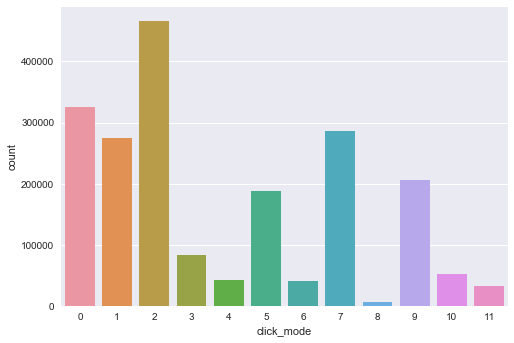

In [51]:
sns.countplot(train_data['click_mode'])

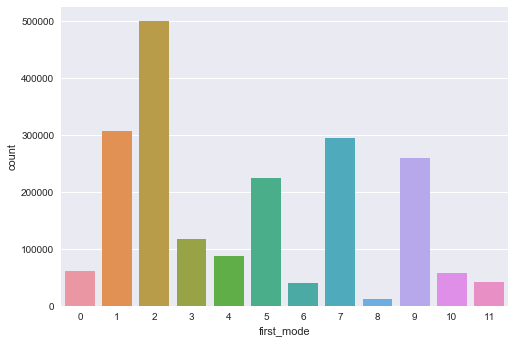

In [52]:
sns.countplot(train_data['first_mode'])

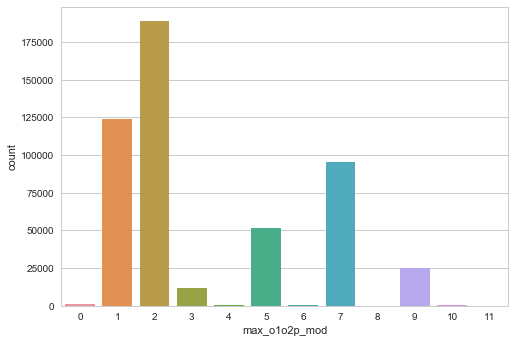

In [224]:
sns.countplot(train_data['max_o1o2p_mod'])

In [201]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,5,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 576x396 with 0 Axes>

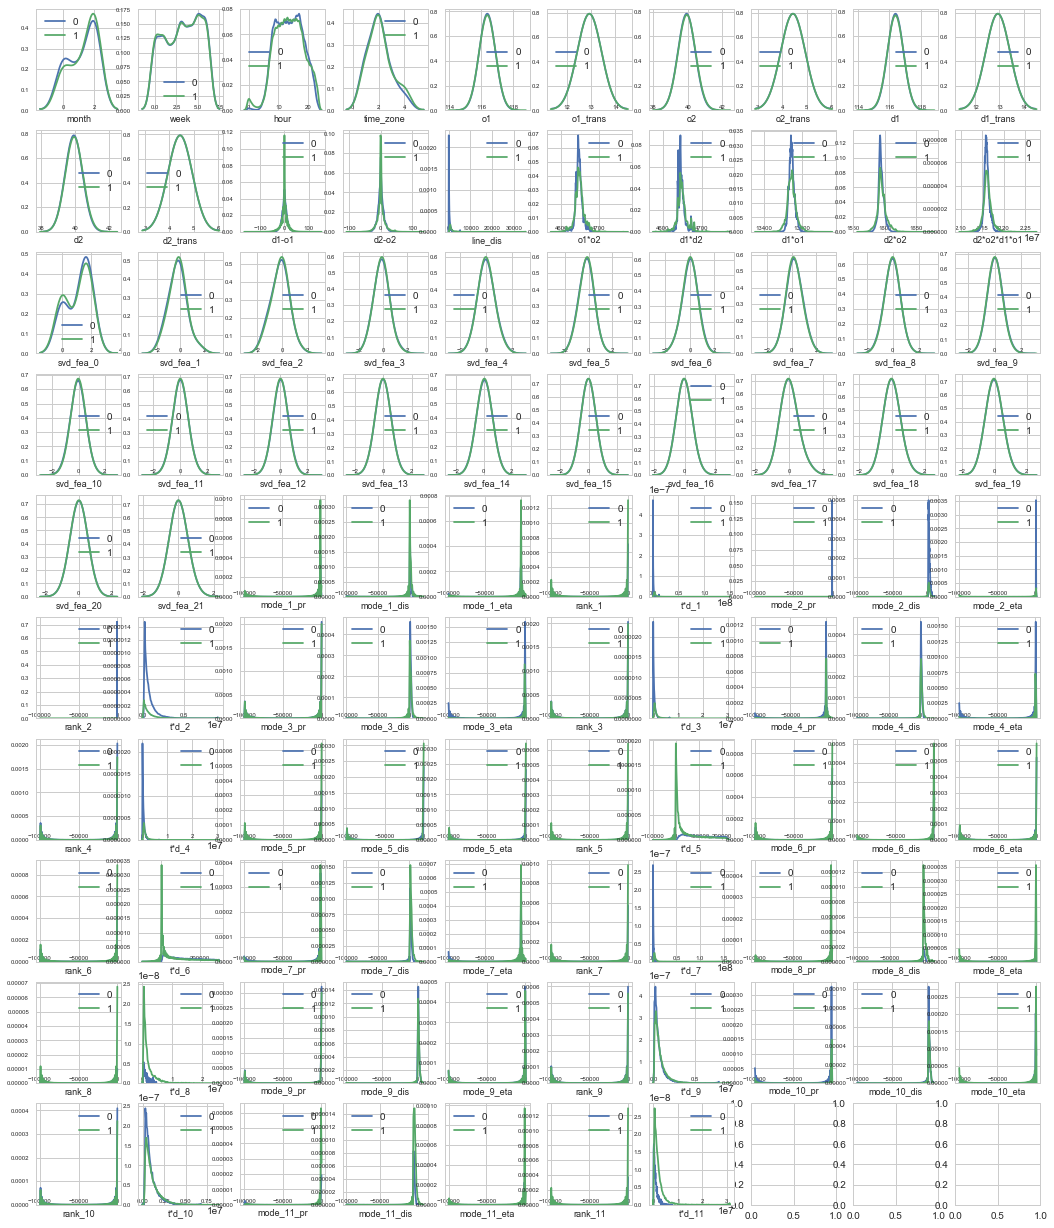

In [198]:
t0 = train_data.loc[train_data['click_mode'] == 2]
t1 = train_data.loc[train_data['click_mode'] != 2]
#t3 = train_data.loc[train_data['click_mode'] == 2]
#t4 = train_data.loc[train_data['click_mode'] == 3]
features = train_data.columns.values[3:100]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 576x396 with 0 Axes>

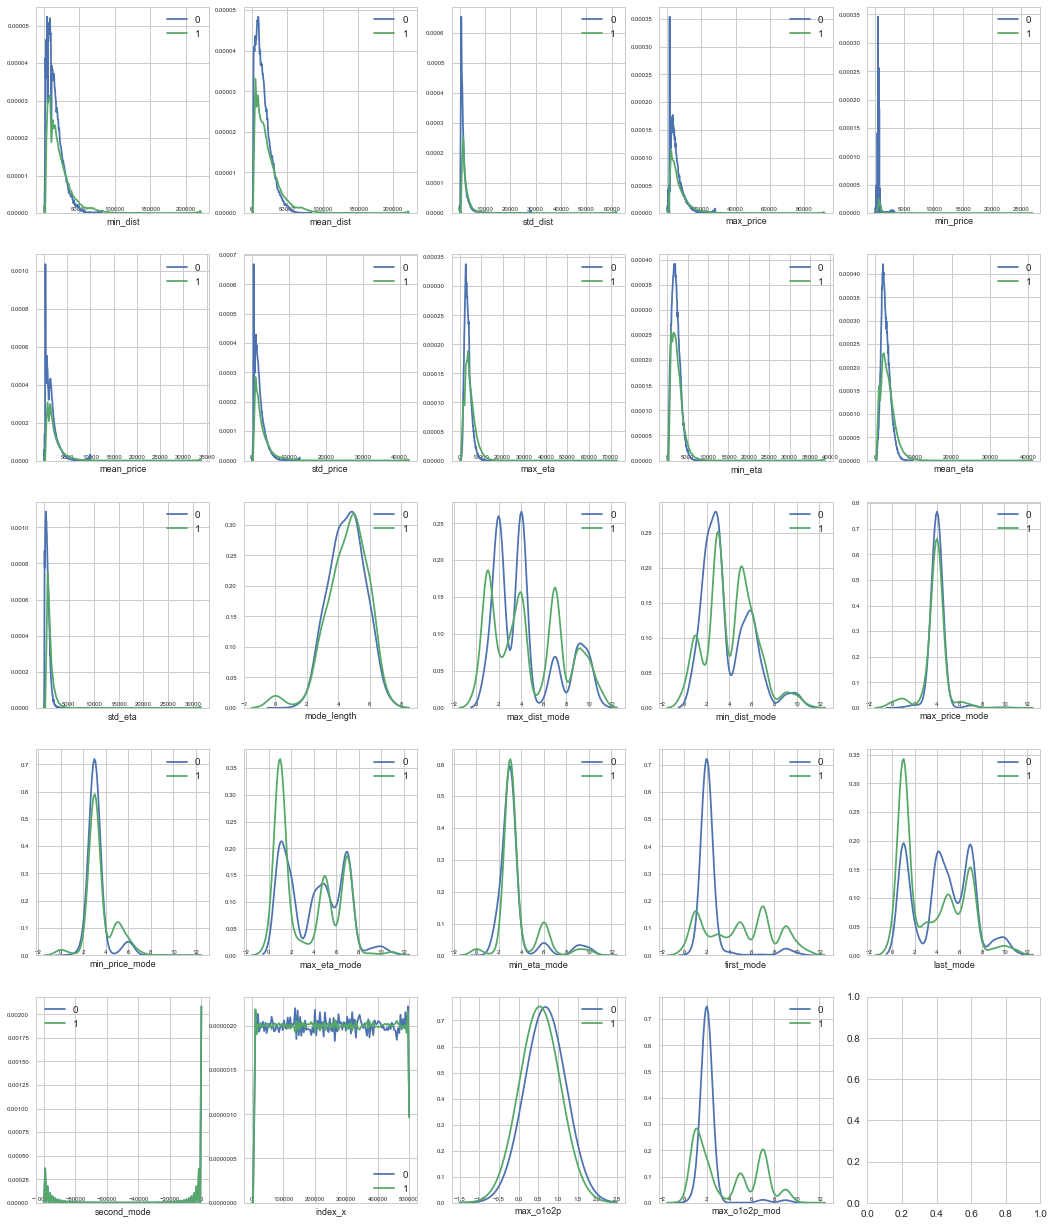

In [203]:
features = train_data.columns.values[101:125]
plot_feature_distribution(t0, t1, '0', '1', features)